# ***Set parameters***

In [1]:
__algo__ = "Spectral"              #Name of the Clustering algorithm
__emb__ = "glove"                #Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__sentemb__ = "pmeans5"          #Name of Sentence Embedding algorithm used
recnum = 3000                   #Number of records to be read from files
k = 50                           #Number of Clusters
usesqrt = False                  #Set value of k to sqrt of recnum, overrides k
randomsample = False             #Random Sampling to be True/False for records which are read
embedDir = "../MegaSentEmbs/"    #Directory where embeddings are saved for that selected embedding
modelDir = "../models/"          #Directory where models are saved
megadfDir = "../MegaDfs/"        #Directory Where Megadf is to be saved
plotDir = "../plots/"            #Directory where plots are saved
dumpDir = "../dump/"             #Directory where test outcomes are saved


# Actual Code

### imports and time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
import seaborn as sns
import os, subprocess
import datetime, time
import pickle
import pyamg

In [3]:
start_time = time.time()
start_datetime = datetime.datetime.now()
print("Start time: ", start_time)
print("Start datetime: ", start_datetime)
# print(datetime.datetime.now()-start_datetime)

Start time:  1586863566.4621606
Start datetime:  2020-04-14 16:56:06.462221


### File Settings

In [4]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
smalllist = filelist[:filenum]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  116


### Number of Records
It is Recommended to Set this at the top parameters

In [5]:
recnum = recnum

### Read all the pandas dataframes

In [6]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  False
megadf.shape:  (3000, 4)
CPU times: user 107 ms, sys: 25.2 ms, total: 132 ms
Wall time: 161 ms


In [7]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(3000, 250)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [8]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  50


## Clustering
Please modify the functions here to change algorithm

In [9]:
%%time
print("Starting Clustering Process")
model = cluster.SpectralClustering(n_clusters=k, eigen_solver="arpack", random_state=42, affinity='nearest_neighbors', n_neighbors=10,  n_init = 20, n_jobs=-1)
# model = cluster.SpectralClustering(n_clusters=k, eigen_solver="arpack", random_state=42, affinity='rbf', n_neighbors=10,  n_init = 20, n_jobs=-1)
# model = cluster.SpectralClustering(n_clusters=k, eigen_solver="arpack")
model.fit(data)
print("Done")
print("k_means.fit(data) Done!")

Starting Clustering Process
Done
k_means.fit(data) Done!
CPU times: user 12.2 s, sys: 94.7 ms, total: 12.3 s
Wall time: 4.79 s


### Saving the output data into vars

In [10]:
affinity = model.affinity_matrix_
labels = model.labels_
megadf["clusterlabel"]=labels
affinityDF = pd.DataFrame(affinity)


## Plotting

Text(0.5, 1.0, 'Spectral with k=50 records=3000 features=250 using glove')

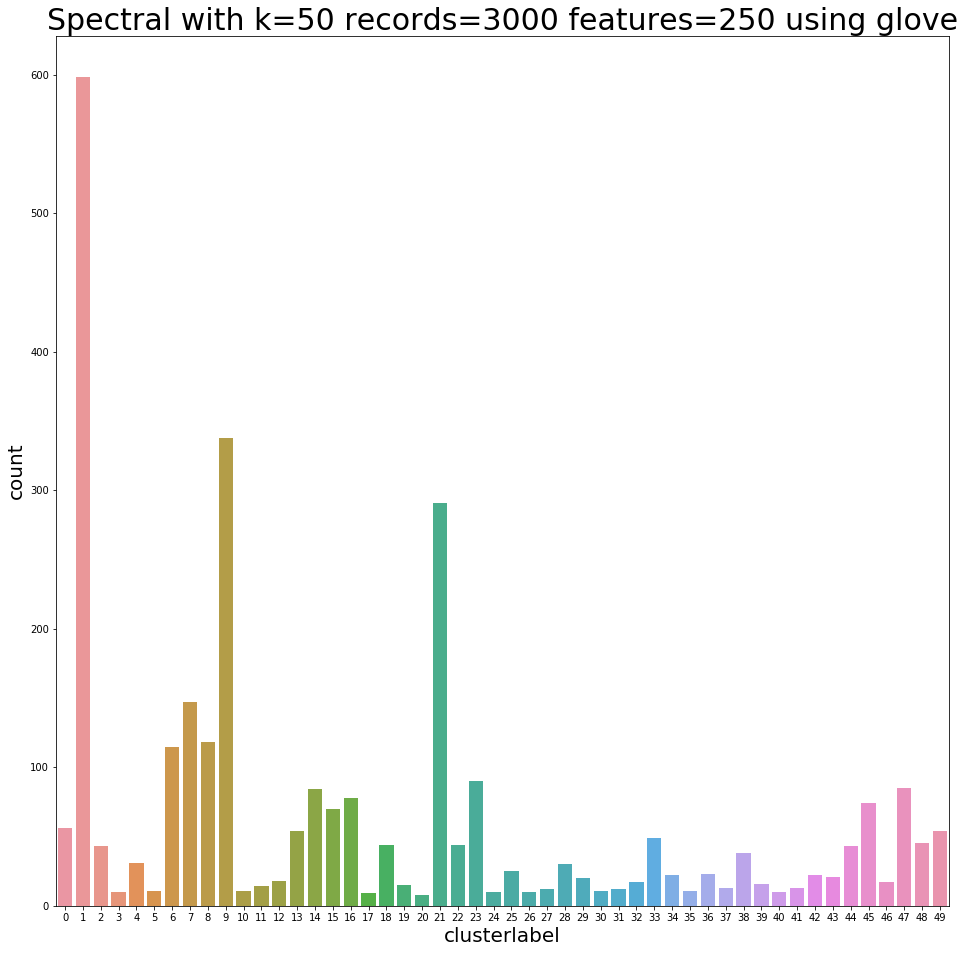

In [11]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [12]:
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, data.shape[0], data.shape[1])
name

'Spectral_glove_pmeans5_K50_R3000_F250'

### Saving Data

Save model

In [13]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))

Save Plot

In [14]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

Save Megadf

In [15]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)

Save Centroids

In [16]:
affinityDF = pd.DataFrame(affinity)
affinityDFname = "{}_affinity.pkl".format(name)
affinityDF.to_pickle(megadfDir + affinityDFname)
print(affinityDF.shape)
print(affinityDF.columns)

(3000, 1)
RangeIndex(start=0, stop=1, step=1)


#### Total Time to Exec

In [17]:
end_time = time.time()
end_datetime = datetime.datetime.now()
# print("end_time:",  end_time)
print("end_datetime: ", end_datetime)
print("done! {}".format(round(end_time-start_time, 2)))
print("Time taken: ", str(end_datetime-start_datetime))

end_datetime:  2020-04-14 16:56:13.062101
done! 6.6
Time taken:  0:00:06.599880


#### Open dataframe to test

In [18]:
sub = megadf.loc[:, ["id", "title", "abstract", "clusterlabel"]]
sub.tail()

,id,title,abstract,clusterlabel
2995,1588822,Defining the clinical role of the mammalian ta...,"[lung, cancer, biggest, cancer, killer, patien...",7
2996,1588823,Bio-functionalised nanoparticles for enzyme se...,"[inorganic, nanoparticles, accompanying, diver...",7
2997,1588824,Lithological mapping on the Antarctic Peninsul...,"[antarctic, peninsula, larger, uk, limited, ge...",21
2998,1588825,"WWOX, tumour suppressor and modifier gene, as ...","[wwox, tumour, suppressor, gene, demonstrated,...",7
2999,1588826,Improving efficiency in drive lines : an exper...,"[research, concern, improvement, power, effici...",21


In [19]:
megadf.columns

Index(['id', 'title', 'abstract', 'embedding', 'clusterlabel'], dtype='object')